In [37]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetchHousingData(housingUrl = HOUSING_URL, housingPath = HOUSING_PATH):
    if not os.path.isdir(housingPath):
        os.makedirs(housingPath)
    tgzPath = os.path.join(housingPath, "housing.tgz")
    urllib.request.urlretrieve(housingUrl, tgzPath)
    housing_tgz = tarfile.open(tgzPath)
    housing_tgz.extractall(path=housingPath)
    housing_tgz.close()

In [38]:
import pandas as pd

def loadHousingData(housingPath = HOUSING_PATH):
    csvPath = os.path.join(housingPath, "housing.csv")
    return pd.read_csv(csvPath)

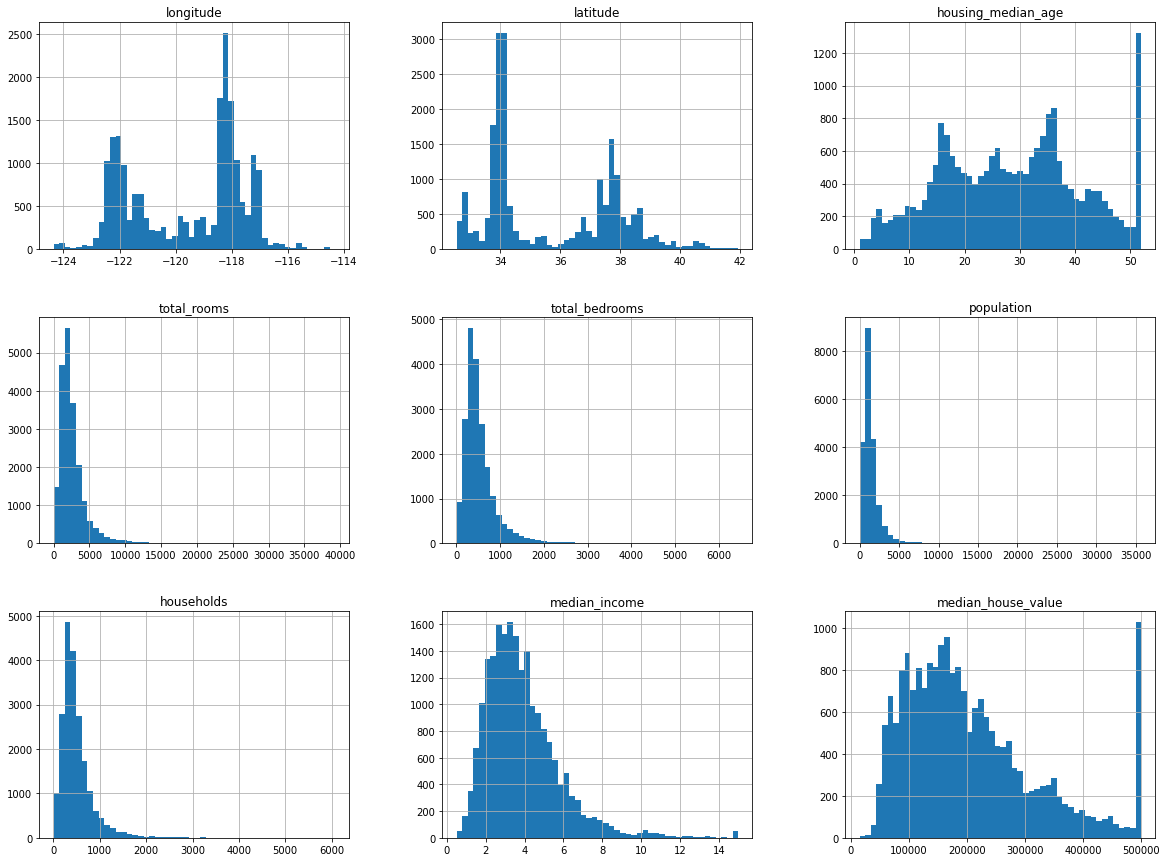

In [39]:
%matplotlib inline
housing = loadHousingData()
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [40]:
import numpy as np

# Possibly bad imlementation of splitting, new split each time this is run
# Scikit-Learn has functions that does this + can choose random seed:
# from sklearn.model_selection import train_test_split
# trainSet, testSet = train_test_split(housing, test_size=0.2, random_state=42)
# can also split according to different DataFrame with same #rows

def splitTrainTest(data, testRatio):
    shuffledIndices = np.random.permutation(len(data))
    testSetSize = int(len(data) * testRatio)
    testIndices = shuffledIndices[:testSetSize]
    trainIndices = shuffledIndices[testSetSize:]
    return data.iloc[trainIndices], data.iloc[testIndices]

In [41]:
from zlib import crc32

def testSetCheck(identifier, testRation):
    return crc32(np.int64(indentifier) & 0xffffffff < testRation * 2 ** 32)

# Better implementation of splitting, computes hash of some identifier and compares to testRatio * max hash value
# Row index could be an identifier, new data at the end and no rows must be deleted
# Districts geographical location is a stable identifier no matter new or old data
# Example:
# housingWithId["id"] = housing["lonitude"] * 1000 + housing["latitude"]
# trainSet, testSet = =splitTrainTestById(housingWithId, 0.2, "id")

def splitTrainTestById(data, testRation, idColumn):
    ids = data[idColumn]
    inTestSet = ids.apply(lambda id_: testSetChec(id_, testRatio))
    return data.loc[-inTestSet], data.loc[inTestSet]

# Note on sampling methods
Random sampling is find if datasets are larg enough, if not there is possibilty of sampling bas.
Don't call 1000 random people to represent population, choose 1000 people that do represent population <- _stratified sampling_

In [42]:
# Housing income is continuous attribute, make into categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3., 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

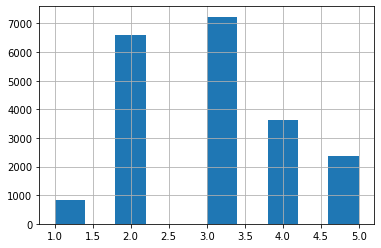

In [43]:
housing["income_cat"].hist()

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit

# Now we use stratified sampling in the housing DataFrame
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for trainIdx, testIdx in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[trainIdx]
    strat_test_set = housing.loc[testIdx]

In [51]:
# Check proportions in income category of stratified test set, should be close to full data set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

# Remove income category so data is back to original, we have split up data in representative groups so don't need it anymore.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

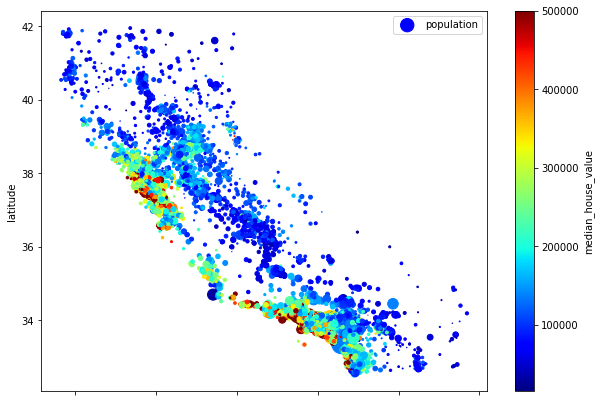

In [52]:
housing = stratTrainSet.copy()
# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=.1) # alpha: more dense more opacity
housing.plot(kind="scatter", x="longitude", y="latitude", 
            s=housing["population"]/100, label="population", figsize=(10, 7), # s: size of scatter points
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, # c: column represented by color
            )
plt.legend()

In [53]:
corrMatrix = housing.corr() # Matrix of correlation between two attributes, [-1, 1]
corrMatrix["median_house_value"].sort_values(ascending=False) # How correlated other attributes are with median_hous_value

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

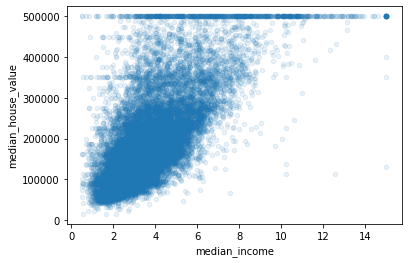

In [54]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# scatter_matrix(housing[attributes], figsize=(12, 8)) # Matrix of scatter plots of attribute x attribute
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=.1)

In [55]:
# Some attributes are useless, like total rooms in district -> rooms / household
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
corrMatrix = housing.corr()
# corrMatrix["median_house_value"].sort_values(ascending=False)

In [56]:
# Data transformations
housing = stratTrainSet.drop("median_house_value", axis=1) # Drop the labels
housing_labels = stratTrainSet["median_house_value"].copy() # Separate DataFrame for labels

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # Fill missing values with median value

housing_num = housing.drop("ocean_proximity", axis=1) # Only numerical attributes, type of median
imputer.fit(housing_num) # Learns median of all atttributes in housing_num
imputer.fit_transform(housing_num) # Equivalent of fit() then transform(), sometimes faster
# imputer.statistics_ # Where learned medians are stored
# housing_num.median().values # True medians
x = imputer.transform(housing_num) # Puts learned median in missing places, returns np.array
housing_tr = pd.DataFrame(x, columns=housing_num.columns) # Makes pd DataFrame out of x using housing_num as template

In [57]:
# Do something about the dropped "ocean_proximity"
housing_cat = housing[["ocean_proximity"]]

# This learns what values an attribute takes and converts it from text to number.
# '<1H OCEAN -> 1, 'INLAND' -> 2 etc.
# May be flawed, ML algorithms will assume 1 and 2 are more similar than 1 and 4: works for oredered categories

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder() 

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) 
# housing_cat_encoded[:10] # What new DataFrame looks like
# ordinal_encoder.categories_ # Show categories ordinal_encoder learned from

# Better use one-hot encoding
# Creates binary attribute per category, notion of similarity is gone
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) # Outputs np sparse array
# housing_cat_1hot # Show new DataFrame
# cat_encoder.categories_ # show categories cat_encoder learned from

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5 , 6

# Class to combine attributes like earlier, integrates well with scikit-Learn API
# BaseEstimator and TransformerMixin are base classes of Scikit-Learn from which we derive this one
# add_bedrooms_per_room is True by default, possibly fishy attribute, this makes it easy to use or not
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, x, y=None):
        return self # nothing else to do ?
    def transform(self, x, y=None):
        rooms_per_household = x[:, rooms_ix] / x[:, households_ix]
        population_per_household = x[:, population_ix] / x[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = x[:, bedrooms_ix] / x[:, rooms_ix]
            return np.c_[x, rooms_per_household, population_per_household, 
                         bedrooms_per_room]
        else:
            return np.c_[x, rooms_per_household, population_per_household]
        
attrAdder = CombinedAttributesAdder(add_bedrooms_per_room=False) # Create object of class above
housing_extra_attribs = attrAdder.transform(housing.values) # combine attributes in housing

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Creates pipeline of transformation on numerical features 
# for now: imputer (add missing values) -> attribs_adder (create new attributes) -> std_scaler (scales features through standardization)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num) # Transformed numerical DataFrame

In [60]:
from sklearn.compose import ColumnTransformer
# New pipeline composing num_pipeline and OneHotEncoder
num_attribs = list(housing_num) # Numerical attributes
cat_attribs = ["ocean_proximity"] # Categorical attributes


full_pipeline = ColumnTransformer([ # list of tuples (name, transformer, list of attributes)
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    # Unspecified attributes will, by default, be dropped
    # Transformer can also be 'drop' or 'pass through', to drop of ignore attributes respectively
    # Setting hyperparameter remainder to what should be done with unspecified attributes
])

housing_prepared = full_pipeline.fit_transform(housing) # Final test set of housing

In [61]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() # Instance of linear regression model
lin_reg.fit(housing_prepared, housing_labels) # Learn from housing_prepared

LinearRegression()

In [62]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Lables: ", list(some_labels))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Lables:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [63]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
# lin_rmse # 68627.87390018745 very bad.

In [64]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
# tree_rmse # 0.0, model is strongly overfitting

In [65]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring ="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores) # cross_val_score measures utility

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
    
display_scores(tree_rmse_scores)
display_scores(lin_rmse_scores)

Scores:  [71722.31133349 70474.55214671 68802.41765924 72968.35807799
 67277.13185877 78734.21977741 70413.43813119 73522.70034198
 69777.15574426 70299.22292048]
Mean:  71399.15079915311
Standard Deviation:  3004.6768272906015
Scores:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean:  69104.07998247063
Standard Deviation:  2880.3282098180694


In [66]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

18752.030906740103
Scores:  [51398.92693813 48954.03463992 47366.07393159 52067.17158707
 47260.63405513 51947.72638194 52416.75795057 49500.54991239
 48715.63629332 54146.18197544]
Mean:  50377.36936654963
Standard Deviation:  2215.0863855345538


In [67]:
from sklearn.model_selection import GridSearchCV

# Search through paramater space to find optimal parameters
param_grid = [
    {'n_estimators': [3, 10, 3], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error",
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 3]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [74]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"]

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49473.743922644964